### IMPORTS

In [67]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

import pandas as pd
from collections import Counter
import pprint
from random import shuffle
from IPython.display import Image
import time

pd.set_option("display.max_rows", 100)

### GLOBAL VARIABLES

In [68]:
client_ID = "bef34a7d63ba4ace8e7dc8c05de24591"

with open("secret.txt") as file:
    client_secret = file.read()[:-1]
    
sp = spotipy.Spotify(
    client_credentials_manager = SpotifyClientCredentials(
        "{}".format(client_ID), "{}".format(client_secret)))

host = "m11oiwplfr6aqk5svov48b40w"

find_URI = Image("find_spotify_URI.png", width = 400, height = 50)

genres = []

### USERS IDENTIFICATION

spotify:user:sedepa//spotify:user:1163173670//spotify:user:119404049//spotify:user:azaba//spotify:user:diegolriveiro//spotify:user:1225636143//spotify:user:1152012320//spotify:user:luisarguel//spotify:user:alvarodiaztort//spotify:user:ycz169eekj80gcmz8jrifxit1//spotify:user:1116864324

In [69]:
def receive_users():
    
    print("Enter the Spotify URIs of the profiles you would like to link.\n")
    print("You can easily find your profile URI by following these 4 steps on the Spotify app:\n")
    display(find_URI)
    users_input = input("\n Paste your Spotify URIs ('spotify:user:username') here, separating them by '//':"
                        ).split("//")

    users = {}
    for user in users_input:
        display_name = sp.user(user[13:])["display_name"]
        if display_name != None:
            users[user[13:]] = display_name
        else:
            users[user[13:]] = user[13:]
        
    return users

### OBTAIN USERS' PLAYLISTS

In [70]:
def get_user_playlists(users):
    
    users_playlists_names = {}
    users_playlists_names_IDs = {}
    
    for user in users:
        playlists = sp.user_playlists(user)
        playlists_names = []
        users_playlists_names_IDs[user] = {}
        
        for i, playlist in enumerate(playlists["items"]):
            playlists_names.append(playlist["name"])
            users_playlists_names_IDs[user][playlist["name"]] = playlist['uri'][17:]
            
        users_playlists_names[user] = playlists_names
        
    
    mygroup = {"users": {}}
    for user in users:
        mygroup["users"][user] = {} 
        
        
        
    for user in users:
        mygroup["users"][user]["playlists"] = input(
            """
            ·················································
            ·················································
            ·················································
            
            {} , enter the Spotify playlists you would like to upload, separated by '//'. 
                        
            These are all your public playlists: 
    
            {} 
            
            
            If you want to submit all, just write "all"
                        
            """
            .format(users.get(user), users_playlists_names[user])).split("//")
    
        mygroup["users"][user]["genres"] = input(
            """
            ·················································
            ·················································
            ·················································
            
            {} , now select the genres of the songs for your new playlist.
                        
            You can select out of the following:
    
            {} 
            
            
            If you don't want to filter by genre, just write "any"
            
            Again, separate by '//'
                        
            """
            .format(users.get(user), genres)).split("//")


    mygroup["new_playlist_name"] = input(
            """
            ·················································
            ·················································
            ·················································
            
            And finally, write the name for your new combined playlist :D            
            
            """
            )
    
        
    return users_playlists_names_IDs, mygroup

### OBTAIN TRACKS INFO

In [71]:
def get_tracks_info(users_playlists_names_IDs, mygroup):
    
    start_time = time.time()
    
    users_playlists_tracks = {}
    
    for user in mygroup["users"].keys():
        tracks_info = []
        
        if mygroup["users"][user]["playlists"] == ["all"]:
            for playlist_ID in users_playlists_names_IDs[user].values():
                
                tracks_info.append(sp.user_playlist_tracks(user, playlist_id = playlist_ID))
        
        else:
            for playlist in mygroup["users"][user]["playlists"]:
                tracks_info.append(sp.user_playlist_tracks(user, 
                                                           playlist_id = users_playlists_names_IDs[user][playlist]))
    
        users_playlists_tracks[user] = tracks_info
        
    return users_playlists_tracks, mygroup, start_time

### OBTAIN FINAL TRACKS

In [72]:
def get_final_tracks(users_playlists_tracks, mygroup, start_time):
    
    final_tracks = {}
    
    final_track_names = []
    final_track_IDs = []
    final_track_artists = []

    for user in users_playlists_tracks:
        
        print(user)
        
        # Para cada usuario creo una lista de sus canciones con valores únicos. 
        # Esto lo hago para evitar que un usuario con la misma canción en distintas
        # playlists incluya varias veces la canción en la lista final, dándole mayor 
        # popularidad porque se repite entre sus listas, pero sin que realmente sea 
        # popular entre los distintos perfiles.
        
        user_track_names = []
        user_track_IDs = []
        user_track_artists = []
        
        for playlist in users_playlists_tracks[user]:
            for track in playlist["items"]:
                if track["track"]["name"] not in user_track_names:  # Aquí evito repetición.
                    if track["track"]["album"]["artists"] != []:  
                        if mygroup["users"][user]["genres"] == ["any"]:
                            user_track_names.append(track["track"]["name"])
                            user_track_IDs.append(track["track"]["id"])
                            user_track_artists.append(track["track"]["album"]["artists"][0]["name"])

                        else:
                            artist_id = track["track"]["album"]["artists"][0]["external_urls"]["spotify"][32:]
                            artist_info = sp.artist(artist_id)
                            genre_in_artist = 0
                            for genre in mygroup["users"][user]["genres"]:
                                if genre in artist_info["genres"]:
                                    genre_in_artist += 1
                            if genre_in_artist > 0:
                                user_track_names.append(track["track"]["name"])
                                user_track_IDs.append(track["track"]["id"]) 
                                user_track_artists.append(track["track"]["album"]["artists"][0]["name"])
                            
        for i in range(len(user_track_names)):
            final_track_names.append(user_track_names[i])
            final_track_IDs.append(user_track_IDs[i]) 
            final_track_artists.append(user_track_artists[i])        
            
    
    for i in range(len(final_track_names)):
        final_tracks[final_track_IDs[i]] = [final_track_names[i], final_track_artists[i]]
        
    
    # Hago este shuffle antes de ordenarlos por popularidad para evitar que las canciones con 
    # el mismo número de repeticiones se ordenen según el orden de introducción de los 
    # nombres de usuarios. Lo quiero aleatorio:
    
    shuffle(final_track_IDs)
    final_track_IDs_pop = [item for items, c in Counter(final_track_IDs).most_common() for item in [items] * c]
    
    final_track_IDs_unique = []
    
    for track_ID in final_track_IDs_pop:
        if track_ID not in final_track_IDs_unique:
            final_track_IDs_unique.append(track_ID)
    
    return final_tracks, final_track_IDs_unique, final_track_IDs_pop, mygroup, start_time

### CREATE DATAFRAME FOR DJ

In [73]:
def create_dataframe(final_tracks, final_track_IDs_unique, final_track_IDs_pop, mygroup, start_time):

    tracks = []
    artists = []

    for ID in final_track_IDs_pop:
        if len(tracks) < 100:
            tracks.append(final_tracks.get(ID)[0])
            artists.append(final_tracks.get(ID)[1])

    final_tracks_df = pd.DataFrame(data = [final_track_IDs_pop[:100], tracks, artists],
                                   columns = range(100), 
                                   index = ["ID", "Track", "Artist"]).T
    
    display(final_tracks_df)

    return final_track_IDs_unique, mygroup, start_time

### CREATE PLAYLIST ON SPOTIFY

In [74]:
def create_playlist(final_track_IDs_unique, mygroup, start_time):

    token = util.prompt_for_user_token(host,
                               "playlist-modify-public",
                               client_id = "{}".format(client_ID),
                               client_secret = "{}".format(client_secret),
                               redirect_uri = "https://example.com/callback/")

    sp = spotipy.Spotify(auth = token)
    final_playlist = sp.user_playlist_create(host, mygroup["new_playlist_name"])

    sp.user_playlist_add_tracks(host, final_playlist["uri"][17:], final_track_IDs_unique[:100])

    final_playlist_url = final_playlist["external_urls"]["spotify"]
    
    print("""
          ·················································
          ·················································
          ·················································
          
          Here's your new combined playlist: 
          
          {}
          
          ENJOY!
          """.format(final_playlist["external_urls"]["spotify"])
          )
    
    elapsed_time = time.time() - start_time
    print(elapsed_time)
    

### PIPELINE

Enter the Spotify URIs of the profiles you would like to link.

You can easily find your profile URI by following these 4 steps on the Spotify app:



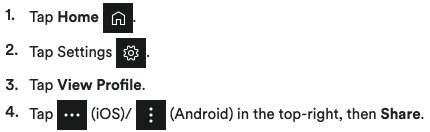


 Paste your Spotify URIs ('spotify:user:username') here, separating them by '//':spotify:user:sedepa//spotify:user:1163173670//spotify:user:119404049//spotify:user:azaba//spotify:user:diegolriveiro//spotify:user:1225636143//spotify:user:1152012320//spotify:user:luisarguel//spotify:user:alvarodiaztort//spotify:user:ycz169eekj80gcmz8jrifxit1//spotify:user:1116864324

            ·················································
            ·················································
            ·················································
            
            José de Pablo , enter the Spotify playlists you would like to upload, separated by '//'. 
                        
            These are all your public playlists: 
    
            ['MAD', 'Sunlight', 'Mana Maoli', 'Talking', 'Chosen one', 'Grandes maestros alemanes del arpa que nacieron en el siglo XX', 'Beatz', 'Interference', 'Movida Milennial', 'Si algún día me convierto en jugador de NBA estos serán mis jams', 


            ·················································
            ·················································
            ·················································
            
            Patricia Estevez , now select the genres of the songs for your new playlist.
                        
            You can select out of the following:
    
            [] 
            
            
            If you don't want to filter by genre, just write "any"
            
            Again, separate by '//'
                        
            any

            ·················································
            ·················································
            ·················································
            
            Ignacio Siska , enter the Spotify playlists you would like to upload, separated by '//'. 
                        
            These are all your public playlists: 
    
            ['chill', 'la Meme', 'Disneylandia', 'N

,ID,Track,Artist
0,2WPHpOOrSoDBOEnV8Cv76w,Famous Blue Raincoat,Leonard Cohen
1,2WPHpOOrSoDBOEnV8Cv76w,Famous Blue Raincoat,Leonard Cohen
2,2WPHpOOrSoDBOEnV8Cv76w,Famous Blue Raincoat,Leonard Cohen
3,2WPHpOOrSoDBOEnV8Cv76w,Famous Blue Raincoat,Leonard Cohen
4,2WPHpOOrSoDBOEnV8Cv76w,Famous Blue Raincoat,Leonard Cohen
5,541hgOF71B92Jpg4IU6kyx,Turnedo,Ivan Ferreiro
6,541hgOF71B92Jpg4IU6kyx,Turnedo,Ivan Ferreiro
7,541hgOF71B92Jpg4IU6kyx,Turnedo,Ivan Ferreiro
8,541hgOF71B92Jpg4IU6kyx,Turnedo,Ivan Ferreiro
9,541hgOF71B92Jpg4IU6kyx,Turnedo,Ivan Ferreiro



          ·················································
          ·················································
          ·················································
          
          Here's your new combined playlist: 
          
          https://open.spotify.com/playlist/6Z6UekrEqR2AS34gmtoAgB
          
          ENJOY!
          
27.311625003814697


In [75]:
if __name__ == '__main__':
    
    users = receive_users()
    
    users_playlists_names_IDs, mygroup = get_user_playlists(users)
    
    users_playlists_tracks, mygroup, start_time = get_tracks_info(users_playlists_names_IDs, mygroup)
    
    final_tracks, final_track_IDs_unique, final_track_IDs, mygroup, start_time = get_final_tracks(users_playlists_tracks, mygroup, start_time)
    
    final_track_IDs_unique, mygroup, start_time = create_dataframe(
        final_tracks, final_track_IDs_unique, final_track_IDs, mygroup, start_time)
    
    create_playlist(final_track_IDs_unique, mygroup, start_time)
    